# Constraints Matrix for PHI

* [Registered Parks and Gardens | Historic England](https://opendata-historicengland.hub.arcgis.com/datasets/historicengland::national-heritage-list-for-england-nhle/explore?layer=7&location=52.990852%2C-1.620726%2C9.42)
* [Spatial inventory of UK waterbodies | CEH](https://catalogue.ceh.ac.uk/documents/b6b92ce3-dcd7-4f0b-8e43-e937ddf1d4eb)
* [Sites of Special Scientific Interest (England) | NE](https://naturalengland-defra.opendata.arcgis.com/datasets/f10cbb4425154bfda349ccf493487a80_0/explore?location=53.241455%2C-1.522016%2C11.22)
* [OS Built Up areas](https://osdatahub.os.uk/downloads/open)

In [12]:
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt

In [11]:
# File paths
boundary_path = './data/peak-district-boundary.shp'
priority_habitats_path = './data/phi-peak-district.shp'
constraints_folder = './data/constraints/'
output_constraints_folder = './data/constraints_clipped/'
merged_constraints_path = './data/constraints-matrix.shp'
final_output_path = './data/constraints-matrix-no-habitats.shp'

# Create output folder if it doesn't exist
os.makedirs(output_constraints_folder, exist_ok=True)

# Load the Peak District boundary
peak_district_boundary = gpd.read_file(boundary_path)

# Initialize a list to store GeoDataFrames for merging
constraints_list = []

# Loop through each file in the constraints folder
for filename in os.listdir(constraints_folder):
    if filename.endswith('.gpkg'):
        input_path = os.path.join(constraints_folder, filename)
        output_path = os.path.join(output_constraints_folder, filename.replace('.gpkg', '.shp'))

        try:
            # Attempt to load the constraint file with default encoding
            constraint_gdf = gpd.read_file(input_path)
        except UnicodeDecodeError:
            # Retry with a fallback encoding
            constraint_gdf = gpd.read_file(input_path, encoding='latin1')

        # Clip to the Peak District boundary
        clipped_gdf = gpd.clip(constraint_gdf, peak_district_boundary)

        # Save the clipped file
        clipped_gdf.to_file(output_path)

        # Append to the list for merging
        constraints_list.append(clipped_gdf)

# Merge all constraints into a single GeoDataFrame
merged_constraints = gpd.GeoDataFrame(pd.concat(constraints_list, ignore_index=True), crs=constraints_list[0].crs)

# Ensure the merged GeoDataFrame contains only polygon geometries
if not merged_constraints.empty:
    merged_constraints = merged_constraints[merged_constraints.geometry.type == 'Polygon']

# Fix invalid geometries in merged_constraints
merged_constraints["geometry"] = merged_constraints.geometry.buffer(0)

# Resolve potential topology issues by dissolving overlapping geometries
merged_constraints = merged_constraints.dissolve()

# Save the merged constraints to a shapefile
merged_constraints.to_file(merged_constraints_path)

# Load priority habitats
priority_habitats = gpd.read_file(priority_habitats_path)

# Fix invalid geometries in priority_habitats
priority_habitats["geometry"] = priority_habitats.geometry.buffer(0)

# Resolve potential topology issues in priority habitats
priority_habitats = priority_habitats.dissolve()

# Subtract priority habitats from the constraints
constraints_minus_habitats = gpd.overlay(merged_constraints, priority_habitats, how='difference')

# Save the final result
constraints_minus_habitats.to_file(final_output_path)

print("Processing complete. The final file is saved at:", final_output_path)

/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'oprvrs_gb.gpkg': 'hydro_node' (default), 'watercourse_link'. Specify layer parameter to avoid this warning.
  result = read_func(
/tmp/ipykernel_13276/1476967372.py:35: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  clipped_gdf.to_file(output_path)
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'hydro_node_category' to 'hydro_node'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/geopandas.py:261: UserWarning: More than one layer found in 'os_open_built_up_areas.gpkg': 'os_open_built_up_areas' (default), 'os_open_built_up_extents', 'os_open_non_built_up_extents'. Specify layer parameter to avoid this warning.
  result = read_func(
/tmp/ipykernel_13276/1476967372.py:35: UserWarning: Colum

Processing complete. The final file is saved at: ./data/constraints-matrix-no-habitats.shp


/tmp/ipykernel_13276/1476967372.py:69: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  constraints_minus_habitats.to_file(final_output_path)
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'hydro_node_category' to 'hydro_node'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'name1_language' to 'name1_lang'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'name2_language' to 'name2_lang'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarning: Normalized/laundered field name: 'areahectares' to 'areahectar'
  ogr_write(
/home/david/anaconda3/envs/np-ons/lib/python3.9/site-packages/pyogrio/raw.py:709: RuntimeWarni

Total Boundary Area: 143782.00 ha
Priority Habitats Area: 65515.74 ha (45.57%)
Constraints Area: 3241.27 ha (2.25%)


/tmp/ipykernel_13276/354298053.py:33: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()
/tmp/ipykernel_13276/354298053.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


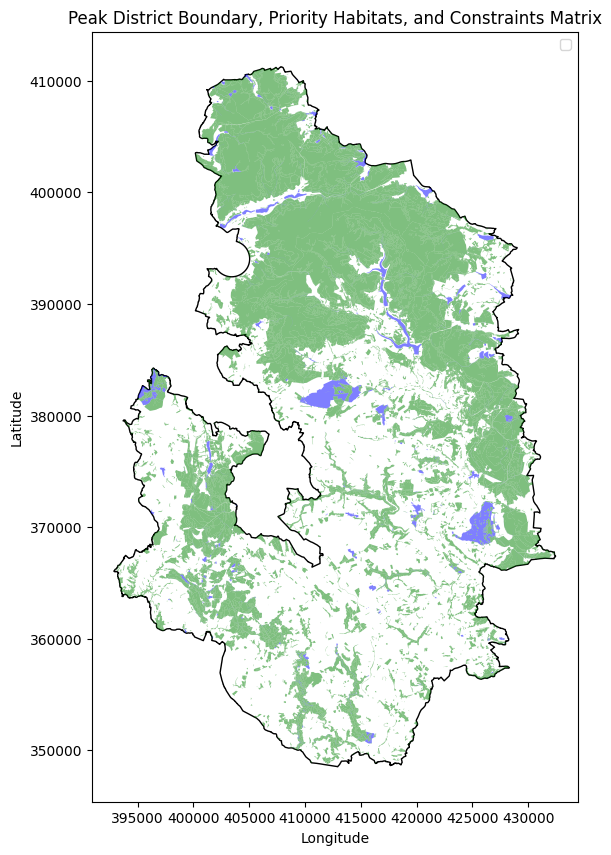

In [14]:
# File paths
boundary_path = './data/peak-district-boundary.shp'
priority_habitats_path = './data/phi-peak-district.shp'
constraints_matrix_path = './data/constraints-matrix-no-habitats.shp'

# Load the GeoDataFrames
boundary = gpd.read_file(boundary_path)
priority_habitats = gpd.read_file(priority_habitats_path)
constraints_matrix = gpd.read_file(constraints_matrix_path)

# Calculate areas in hectares
boundary_area_ha = boundary.geometry.area.sum() / 10000  # Area in hectares
phi_area_ha = priority_habitats.geometry.area.sum() / 10000
constraints_area_ha = constraints_matrix.geometry.area.sum() / 10000

# Calculate proportions
phi_proportion = (phi_area_ha / boundary_area_ha) * 100
constraints_proportion = (constraints_area_ha / boundary_area_ha) * 100

# Print statistics
print(f"Total Boundary Area: {boundary_area_ha:.2f} ha")
print(f"Priority Habitats Area: {phi_area_ha:.2f} ha ({phi_proportion:.2f}%)")
print(f"Constraints Area: {constraints_area_ha:.2f} ha ({constraints_proportion:.2f}%)")

# Plot the layers
fig, ax = plt.subplots(figsize=(10, 10))

boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label='Boundary')
priority_habitats.plot(ax=ax, color='green', alpha=0.5, label='Priority Habitats')
constraints_matrix.plot(ax=ax, color='blue', alpha=0.5, label='Constraints Matrix')

# Customize the plot
plt.legend()
plt.title("Peak District Boundary, Priority Habitats, and Constraints Matrix")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()
